<a href="https://colab.research.google.com/github/BSteiner1/Adversarial-Examples/blob/main/Notebooks/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
!git clone https://github.com/BSteiner1/Adversarial-Examples

Cloning into 'Adversarial-Examples'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 63 (delta 22), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (63/63), 130.04 KiB | 2.41 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [ ]:
import os
os.listdir('Adversarial-Examples/utils')

['__init__.py', 'functions.py']

In [ ]:
from google.colab import drive

%cd /content/Adversarial-Examples

os.listdir()
from utils.functions import *

/content/Adversarial-Examples


In [ ]:
import os
os.listdir('utils')

['__pycache__', '__init__.py', 'functions.py']

In [ ]:
# Load Fashion MNIST dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 26421880/26421880 [00:01<00:00, 14312358.97it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270205.42it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5059340.97it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9038207.20it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
labels_dict = {0 : "T-shirt/top",
               1 : "Trouser",
               2 : "Pullover",
               3 : "Dress",
               4 : "Coat",
               5 : "Sandal",
               6 : "Shirt",
               7 : "Sneaker",
               8 : "Bag",
               9 : "Ankle boot"}

In [ ]:
# Define the CNN model using nn.Sequential
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(32, 64, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(3136, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/MA498/CNN_model.pth'))
model.eval()  # Set the model to evaluation mode

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
def prediction(image, model):

  image_output = model(image.unsqueeze(0))
  image_prediction = torch.argmax(image_output).item()

  class_name = labels_dict[image_prediction]

  return class_name

In [ ]:
def adversarial_example_class(image, epsilon, gradient, model):

  # Create adversarial image
  adversarial_example = image + (epsilon * gradient.sign())
  adversarial_output = model(adversarial_example.unsqueeze(0))
  adversarial_prediction = torch.argmax(adversarial_output).item()

  return adversarial_prediction

In [ ]:
def gen_adversarial_example(image, model):

  # Keep gradients
  image.requires_grad = True

  # Original image class
  output = model(image.unsqueeze(0))
  original_prediction = torch.argmax(output).item()

  # Calculate the loss
  loss = F.cross_entropy(output, torch.tensor([original_prediction]))
  model.zero_grad()

  # Backward pass to compute the gradient of the loss with respect to the input image
  loss.backward()
  gradient = image.grad.data

  # Increment epsilon until classification is wrong
  epsilon = 0
  while adversarial_example_class(image, epsilon, gradient, model) == original_prediction:
    epsilon += 0.01
    #print(epsilon)
    if epsilon > 2:
      return False

  adversarial_example = image + (epsilon * gradient.sign())
  adversarial_prediction = adversarial_example_class(image, epsilon, gradient, model)

  return np.round(epsilon, 2), adversarial_example, adversarial_prediction

In [ ]:
def image_prediction_and_confidence(image, model):

    output = model(image.unsqueeze(0))
    prediction = torch.argmax(output).item()

    # Get the confidence associated with the original prediction
    image_probabilities = F.softmax(output, dim=1)
    confidence = image_probabilities[0, prediction].item()

    return prediction, confidence

In [ ]:
from collections import Counter
import time
import matplotlib.pyplot as plt

In [ ]:
adversarial_class_counter = Counter()

In [ ]:
image = test_dataset[100][0]

In [ ]:
model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
adversarial_image = gen_adversarial_example(image, model)[1]
adversarial_prediction = image_prediction_and_confidence(adversarial_image, model)[0]

In [ ]:
# Get the labels from the dataset
labels = [label for _, label in test_dataset]

# Use Counter to count the occurrences of each class
class_distribution = Counter(labels)

# Print the distribution
for class_label, count in class_distribution.items():
    print(f"Class {class_label}: {count} samples")

Class 9: 1000 samples
Class 2: 1000 samples
Class 1: 1000 samples
Class 6: 1000 samples
Class 4: 1000 samples
Class 5: 1000 samples
Class 7: 1000 samples
Class 3: 1000 samples
Class 8: 1000 samples
Class 0: 1000 samples


In [ ]:
# Get the first 500 images and their labels
first_500 = [image for index, (image, label) in enumerate(test_dataset) if index < 500]
#first_100 = first_500[:300]

In [ ]:
np_count = 0

for i in range(len(first_500)):
  if gen_adversarial_example(first_500[i], model) == False:
    print("Not possible: ", i)
    np_count += 1
  else:
    adversarial_prediction = gen_adversarial_example(first_500[i], model)[2]
    prediction = labels_dict[adversarial_prediction]
    adversarial_class_counter.update({prediction: 1})

Not possible:  18
Not possible:  30
Not possible:  31
Not possible:  58
Not possible:  69
Not possible:  78
Not possible:  81
Not possible:  209
Not possible:  231
Not possible:  256
Not possible:  262
Not possible:  320
Not possible:  424
Not possible:  429
Not possible:  442
Not possible:  443
Not possible:  469
Not possible:  492


In [ ]:
adversarial_class_counter

Counter({'Sneaker': 167,
         'T-shirt/top': 434,
         'Pullover': 295,
         'Coat': 213,
         'Sandal': 186,
         'Shirt': 519,
         'Dress': 154,
         'Ankle boot': 87,
         'Trouser': 37,
         'Bag': 152})

In [ ]:
print("Not possible: ", np_count/10,'%')

Not possible:  3.7 %


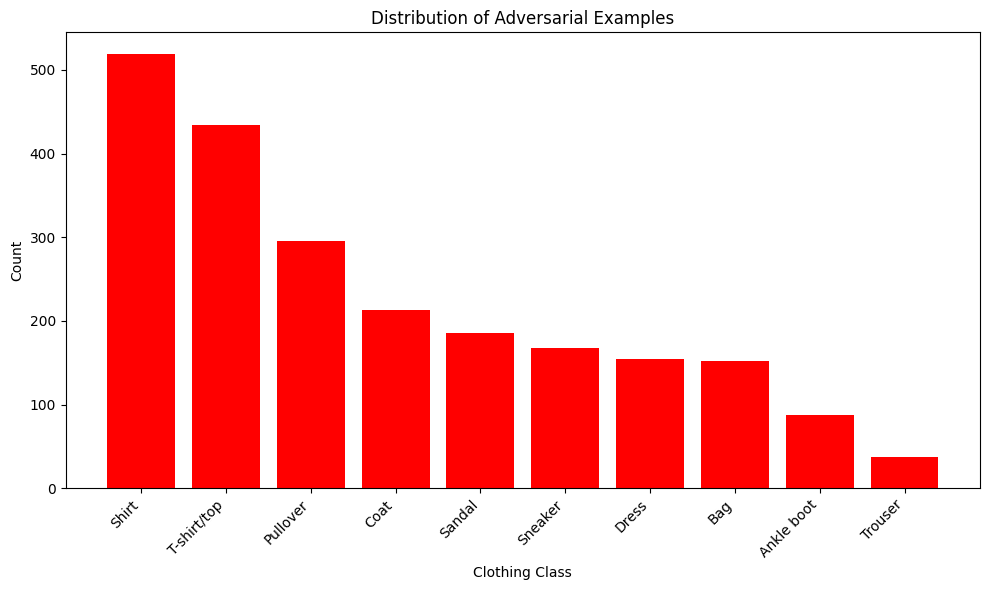

In [ ]:
# Sort the oounter
sorted_counter = dict(sorted(adversarial_class_counter.items(), key=lambda item: item[1], reverse=True))
# Extract labels and counts
labels, counts = zip(*sorted_counter.items())

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='red')
plt.xlabel('Clothing Class')
plt.ylabel('Count')
plt.title('Distribution of Adversarial Examples')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the plot
plt.show()

### Class Means

In [ ]:
# Unpack images and labels from the dataset
images = [image for (image, label) in test_dataset]
labels = [label for (image, label) in test_dataset]

In [ ]:
# Initialize dictionaries to store sums and counts for each class
sums_by_class = {label: None for label in set(labels)}
counts_by_class = {label: 0 for label in set(labels)}

In [ ]:
# Accumulate sums and counts for each class
for tensor, label in test_dataset:
    if sums_by_class[label] is None:
        sums_by_class[label] = torch.zeros_like(tensor)
    sums_by_class[label] += tensor
    counts_by_class[label] += 1

# Calculate the mean input for each class along each component
mean_input_by_class = {label: sums / counts_by_class[label] for label, sums in sums_by_class.items()}

In [ ]:
def dist_from_mean(image, label, mean_image_dict):

  mean_image = mean_image_dict[label]

  euclidean_distance = torch.norm(mean_image - image)

  return euclidean_distance.item()

In [ ]:
dist_from_mean(images[0], labels[0], mean_input_by_class)

12.803854942321777

In [ ]:
len(images)

10000

In [ ]:
images = images[:2000]

In [ ]:
len(images)

2000

In [ ]:
epsilons = []
dists = []

for i in range(len(images)):
  if labels[i] == 5:
    eps = gen_adversarial_example(images[i], model)[0]
    epsilons.append(eps)
    dist = dist_from_mean(images[i], 5, mean_input_by_class)
    dists.append(dist)

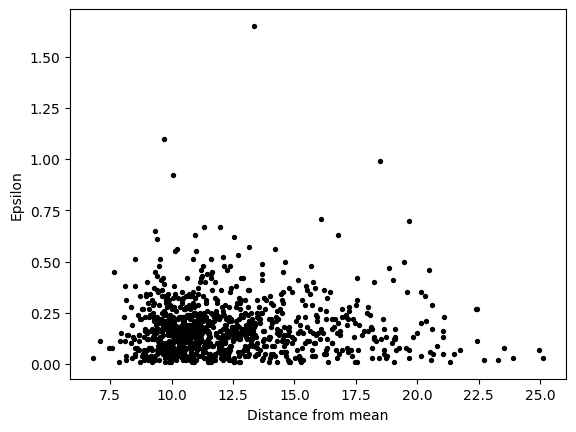

In [ ]:
# Plotting
plt.scatter(dists, epsilons, color='black', s = 8)

# Adding labels and a legend
plt.xlabel('Distance from mean')
plt.ylabel('Epsilon')
#plt.ylim(0, 0.4)
#plt.legend()

# Display the plot
plt.show()

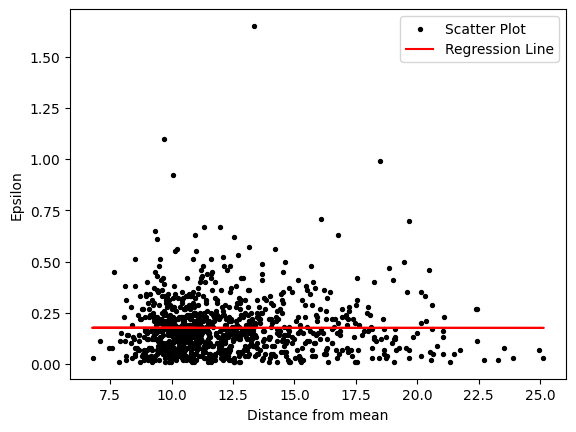

In [ ]:
# Perform linear regression
coefficients = np.polyfit(dists, epsilons, 1)
slope, intercept = coefficients

# Create a regression line function
regression_line = np.polyval(coefficients, dists)

# Scatter plot
plt.scatter(dists, epsilons, color='black', s=8, label='Scatter Plot')

# Plot the regression line
plt.plot(dists, regression_line, color='red', label='Regression Line')

# Adding labels and a legend
plt.xlabel('Distance from mean')
plt.ylabel('Epsilon')
plt.legend()

# Display the plot
plt.show()

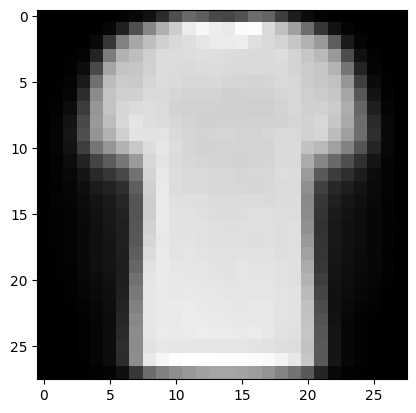

-----------------------------------------------------


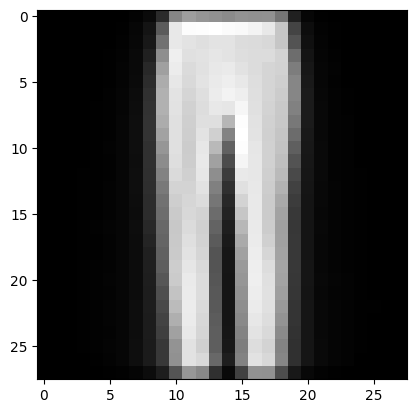

-----------------------------------------------------


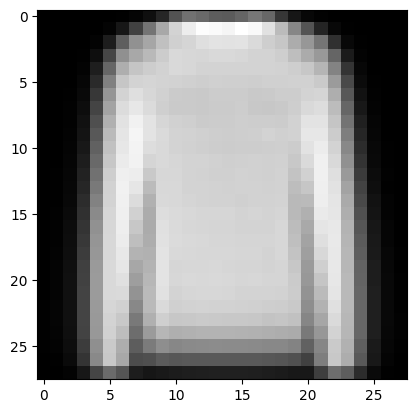

-----------------------------------------------------


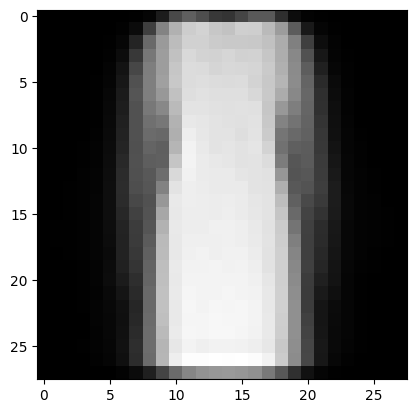

-----------------------------------------------------


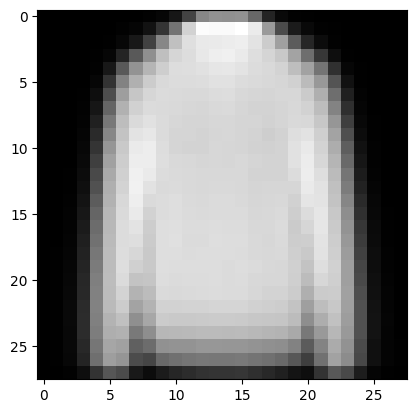

-----------------------------------------------------


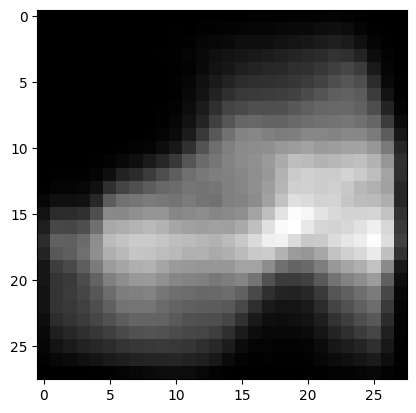

-----------------------------------------------------


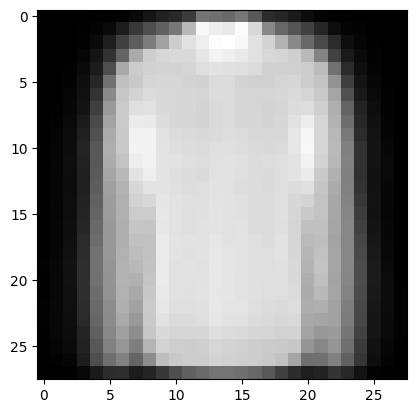

-----------------------------------------------------


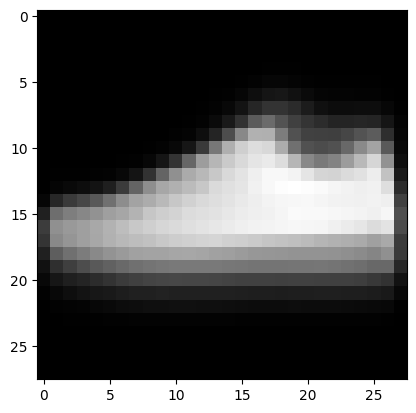

-----------------------------------------------------


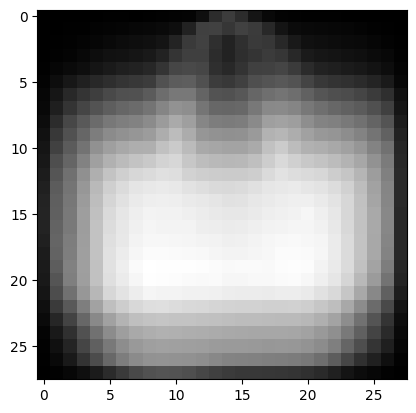

-----------------------------------------------------


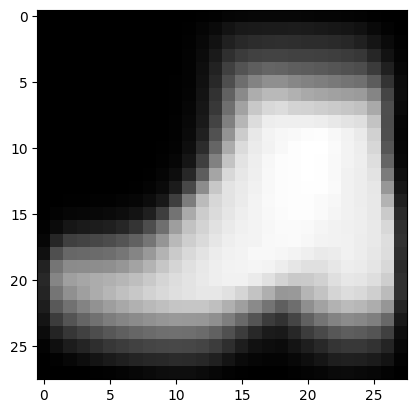

-----------------------------------------------------


In [ ]:
for i in range(10):
  img0 = mean_input_by_class[i]
  img0 = img0.squeeze().detach().numpy()
  plt.imshow(img0, cmap='gray')
  plt.show()
  print("-----------------------------------------------------")

In [ ]:
bag = test_dataset[1900][0]
pullover = test_dataset[2320][0]

In [ ]:
trousers = test_dataset[8200][0]

prediction(trousers, model)

'Trouser'

In [ ]:
def convex_combination(image_one, image_two, model, steps):
  for ld in range(1, steps+1):
    convex_comb = ((steps-ld)/steps)*image_one + (ld/steps)*image_two
    pred = prediction(convex_comb, model)
    print(ld, ":", pred)

In [ ]:
def show_conv_comb(image_one, image_two, frac):
  for f in range(20):
    convex_comb = (f/20)*image_one + ((20-f)/20)*image_two
    convex_comb = convex_comb.squeeze().detach().numpy()
    plt.imshow(convex_comb, cmap='gray')
    plt.show()

In [ ]:
prediction(test_dataset[1900][0], model)

'Bag'

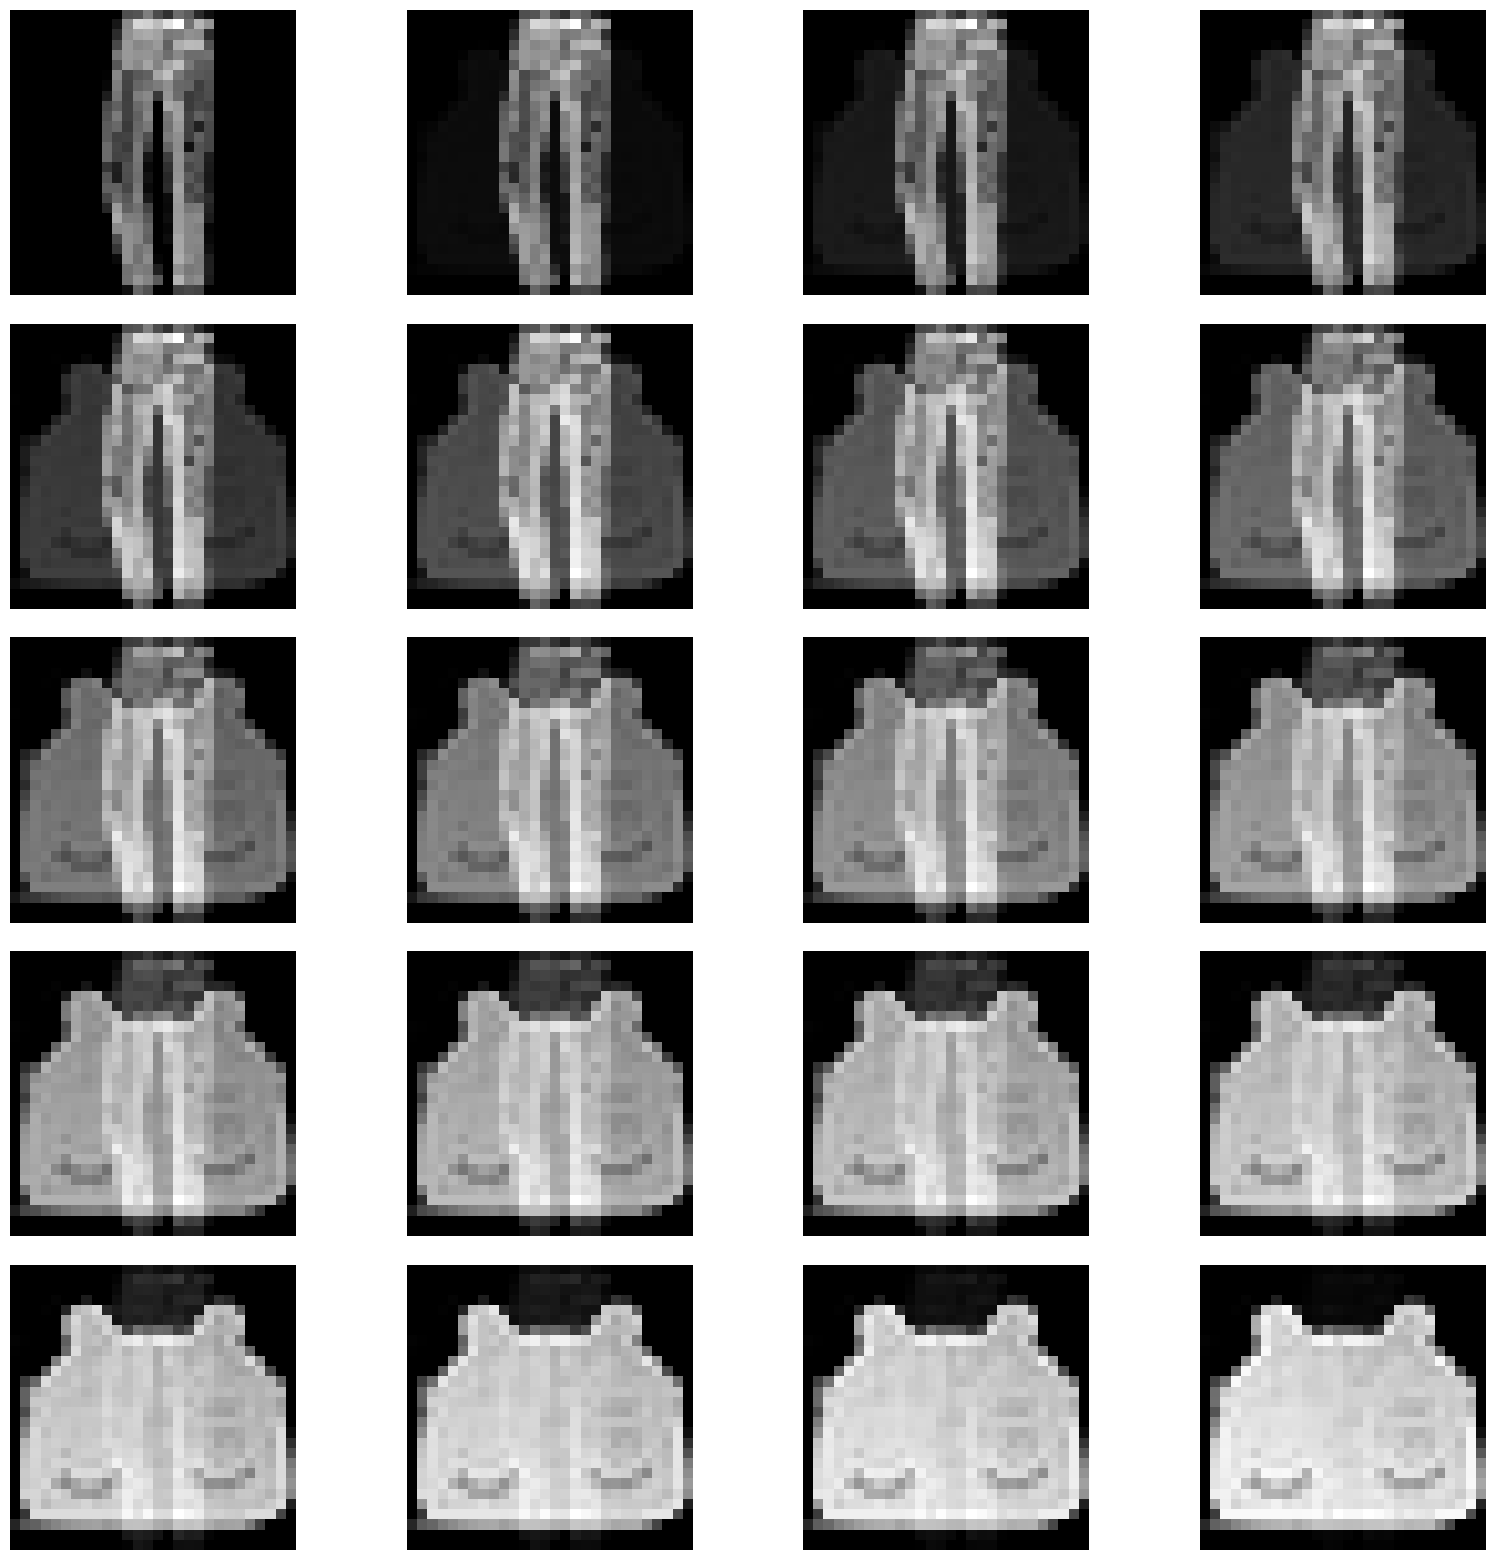

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def show_conv_comb(image_one, image_two, frac):
    fig, axes = plt.subplots(5, 4, figsize=(20, 20))

    for f in range(20):
        i, j = divmod(f, 4)
        convex_comb = (f/20)*image_one + ((20-f)/20)*image_two
        convex_comb = convex_comb.squeeze().detach().numpy()
        axes[i, j].imshow(convex_comb, cmap='gray')
        axes[i, j].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.savefig('conv_comb_output.png')  # Save the combined image
    plt.show()



show_conv_comb(bag, trousers, 0.5)  # Example frac=0.5
from google.colab import files
files.download('conv_comb_output.png')

In [ ]:
adv = gen_adversarial_example(bag, model)[1]

In [ ]:
gen_adversarial_example(bag, model)[0]

1.3

In [ ]:
convex_combination(bag, trousers, model, 20)

1 : Bag
2 : Bag
3 : Bag
4 : Bag
5 : Bag
6 : Bag
7 : Bag
8 : Bag
9 : Bag
10 : Bag
11 : Bag
12 : Bag
13 : Bag
14 : Bag
15 : Shirt
16 : Trouser
17 : Trouser
18 : Trouser
19 : Trouser
20 : Trouser


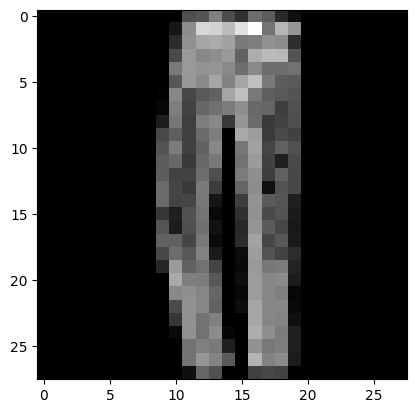

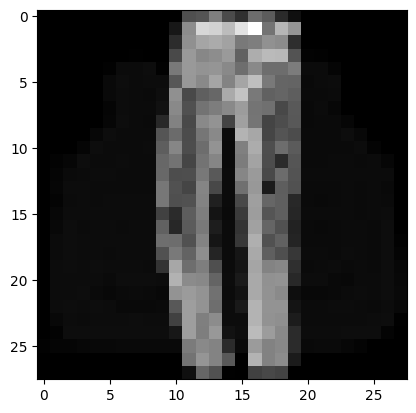

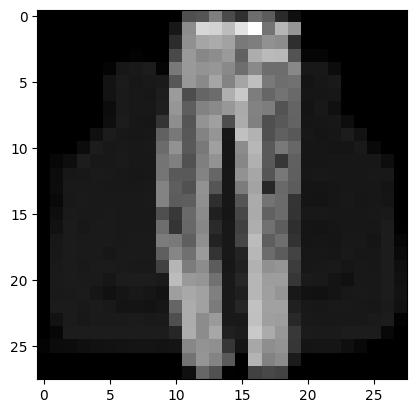

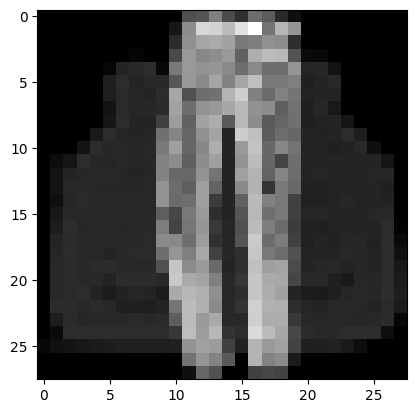

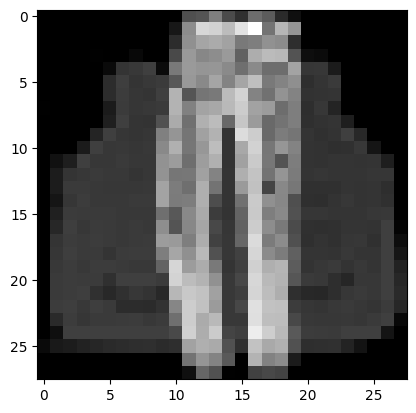

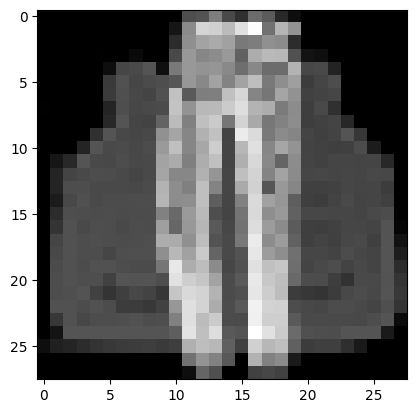

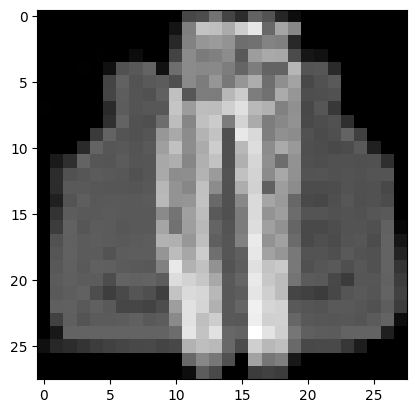

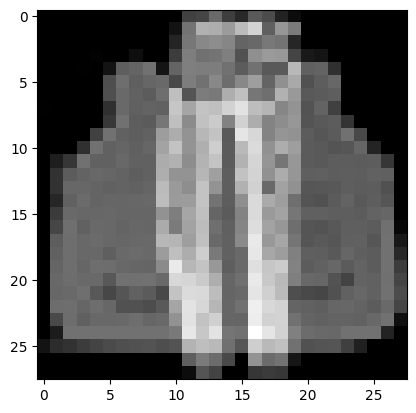

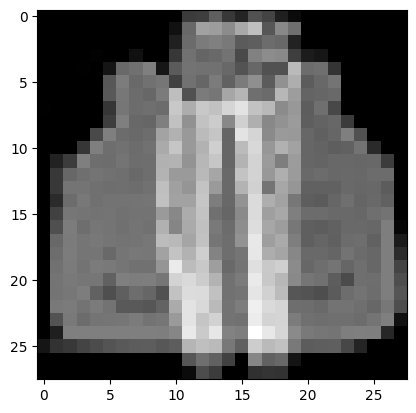

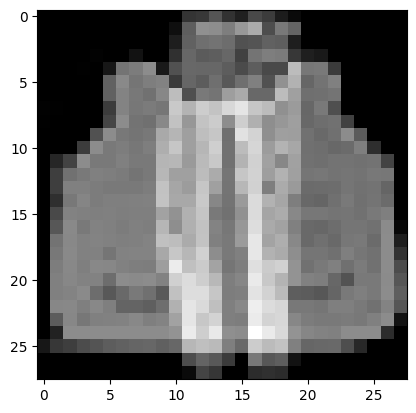

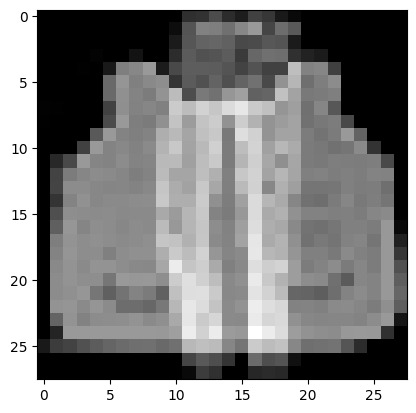

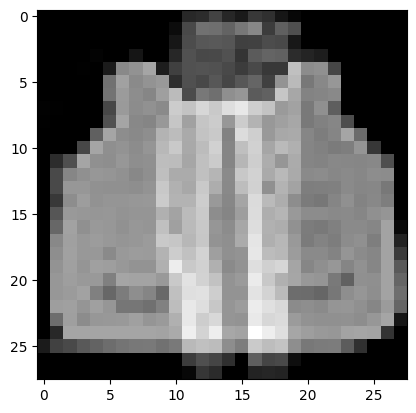

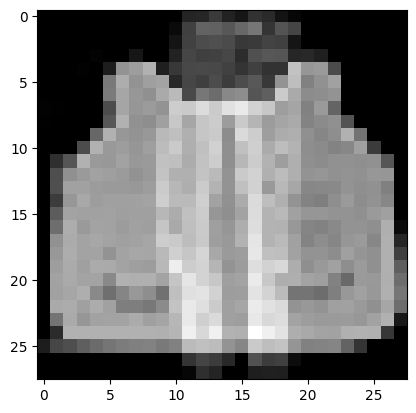

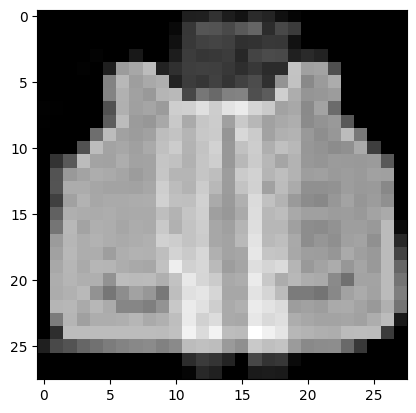

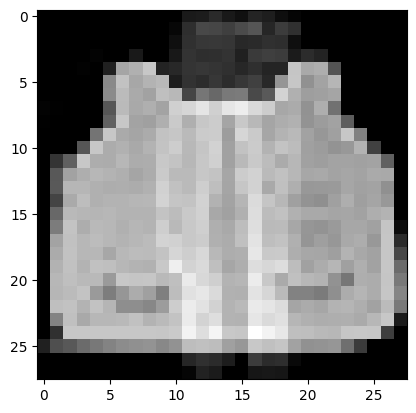

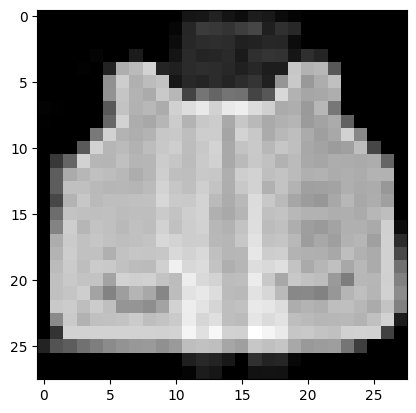

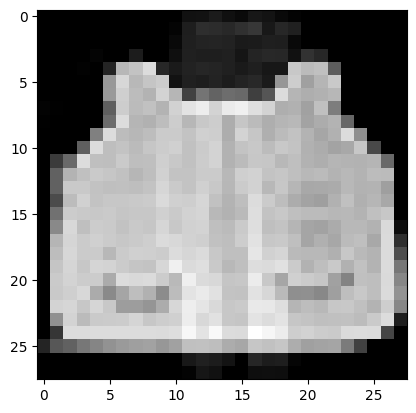

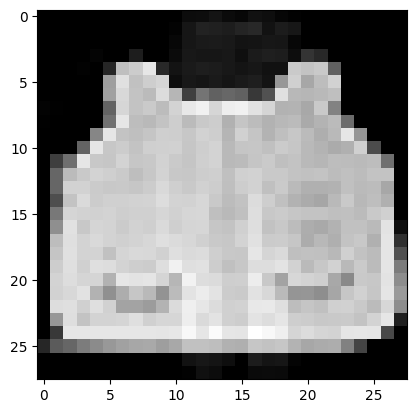

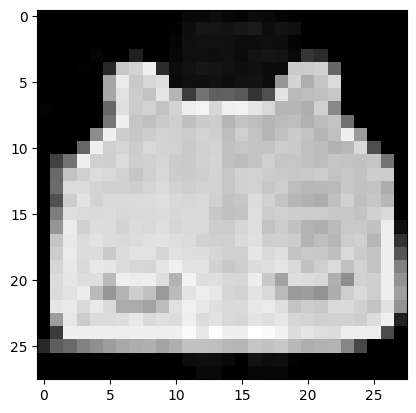

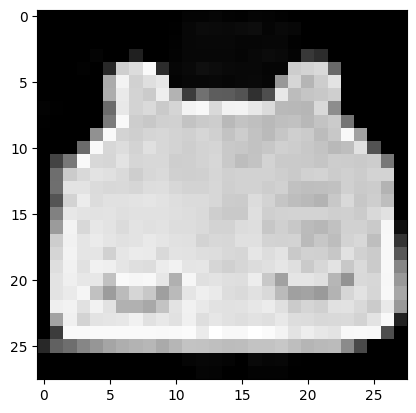

In [ ]:
show_conv_comb(bag, trousers, 15)

In [ ]:
test_dataset[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
start_tensor = torch.full((1, 28, 28), -1)
end_tensor = torch.full((1, 28, 28), 1)

In [ ]:
rand_tensor1 = torch.rand(1, 28, 28)
rand_tensor1 = rand_tensor1*2 -1

In [ ]:
rand_tensor2 = torch.rand(1, 28, 28)
rand_tensor2 = rand_tensor2*2 -1

In [ ]:
curr = 0
steps = 1000

for ld in range(1, 1000):
    convex_comb = ((steps-ld)/steps)*bag + (ld/steps)*pullover
    pred = prediction(convex_comb, model)
    if pred != curr:
      curr = pred
      print(ld/steps, ":", curr)

0.001 : Bag
0.433 : Pullover


In [ ]:
prediction(rand_tensor1, model)

'Bag'

In [ ]:
rand_tensor1 = rand_tensor1.squeeze().detach().numpy()
plt.imshow(trousers, cmap='gray')
plt.show()

NameError: name 'rand_tensor1' is not defined

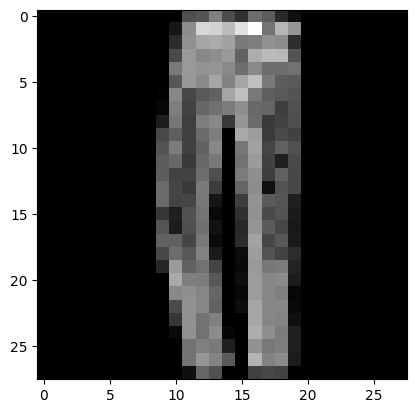

In [ ]:
plt.imshow(trousers.squeeze().detach().numpy(), cmap='gray')
plt.show()

In [ ]:
for i in range(10):
  convex_comb = (i/20)*bag + (i/20)*trousers
  convex_comb = convex_comb.squeeze().detach().numpy()
  plt.imshow(convex_comb, cmap='gray')
  plt.show()
  print("-----------------------------------------------------")

NameError: name 'f' is not defined